Epoch 0: Loss = 6.16075e+03
Epoch 100: Loss = 8.61676e+00
Epoch 200: Loss = 7.67279e+00
Epoch 300: Loss = 7.03545e+00
Epoch 400: Loss = 6.44497e+00
Epoch 500: Loss = 5.91847e+00
Epoch 600: Loss = 5.45336e+00
Epoch 700: Loss = 5.04104e+00
Epoch 800: Loss = 4.67244e+00
Epoch 900: Loss = 4.33990e+00
Epoch 1000: Loss = 4.03740e+00
Epoch 1100: Loss = 3.76039e+00
Epoch 1200: Loss = 3.50541e+00
Epoch 1300: Loss = 3.26982e+00
Epoch 1400: Loss = 3.05155e+00
Epoch 1500: Loss = 2.84886e+00
Epoch 1600: Loss = 2.66016e+00
Epoch 1700: Loss = 2.48387e+00
Epoch 1800: Loss = 2.31866e+00
Epoch 1900: Loss = 2.16511e+00
Epoch 2000: Loss = 2.02961e+00
Epoch 2100: Loss = 1.92516e+00
Epoch 2200: Loss = 1.85841e+00
Epoch 2300: Loss = 1.81885e+00
Epoch 2400: Loss = 1.79231e+00
Epoch 2500: Loss = 1.77211e+00
Epoch 2600: Loss = 1.75636e+00
Epoch 2700: Loss = 1.74442e+00
Epoch 2800: Loss = 1.73577e+00
Epoch 2900: Loss = 1.72978e+00
Epoch 3000: Loss = 1.73321e+00
Epoch 3100: Loss = 1.72487e+00
Epoch 3200: Loss = 1

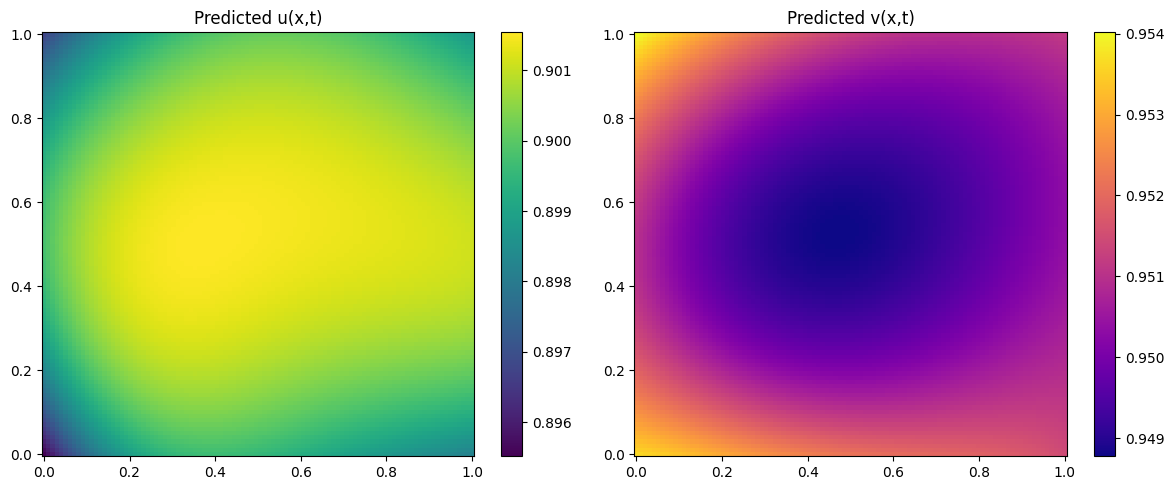

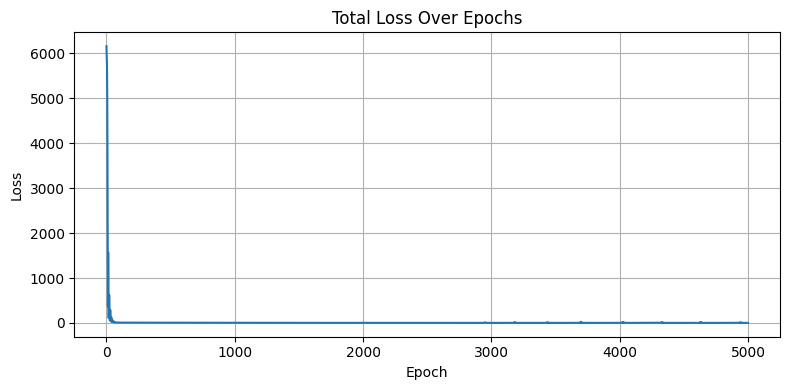

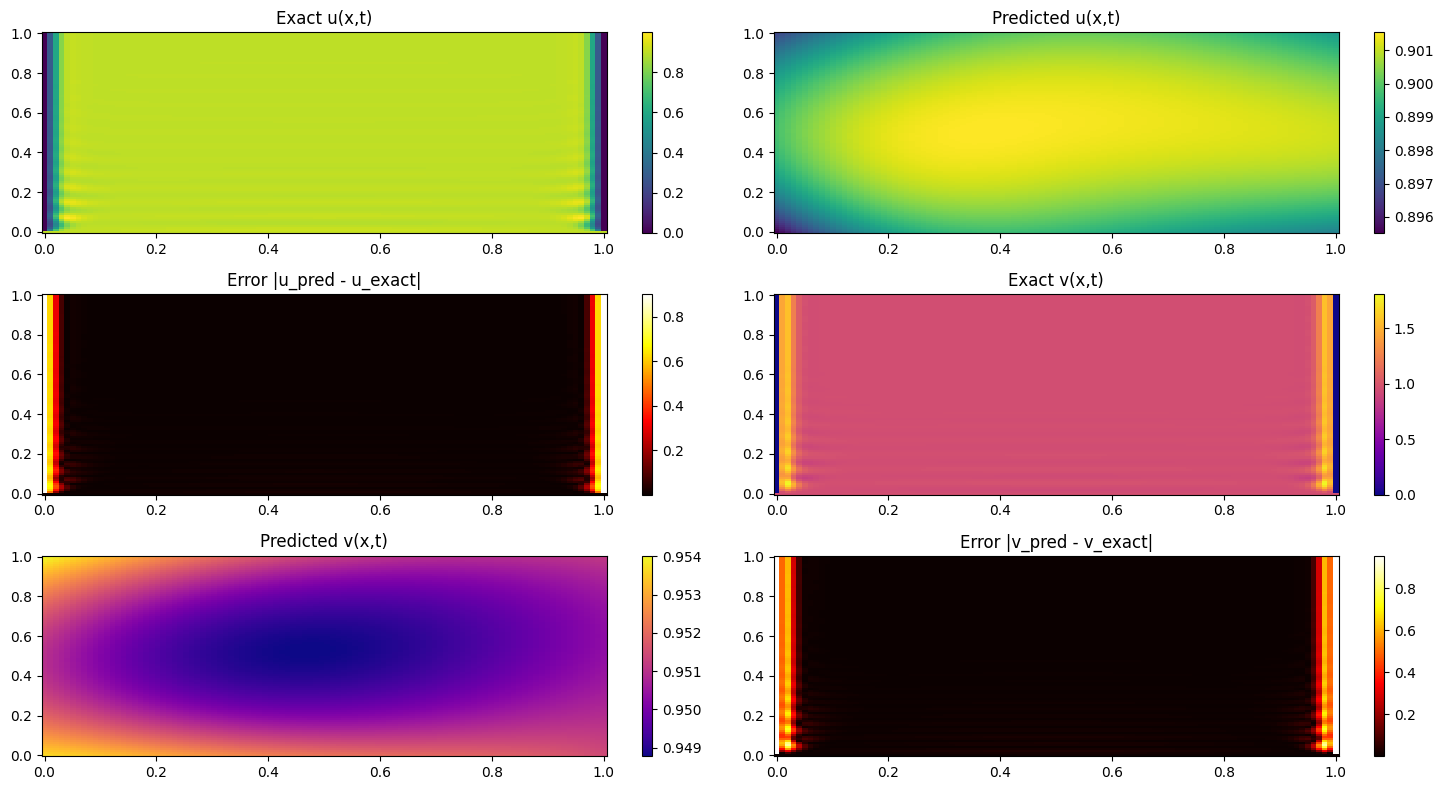

In [5]:
# ----------------------------
# PINN for 1D Reaction-Diffusion System: Schnakenberg Model
# ----------------------------

# ## Part 1. Problem Setup
# In this example, we solve a 1D reaction-diffusion system known as the Schnakenberg model:
#
#     ∂u/∂t = D_u ∂²u/∂x² + γ(a - u + u²v)
#     ∂v/∂t = D_v ∂²v/∂x² + γ(b - u²v)
#
# The goal is to approximate the solution (u(x,t), v(x,t)) using a Physics-Informed Neural Network (PINN).
# This system is capable of generating spatiotemporal patterns and is widely used to study chemical or biological pattern formation.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)

# ## Part 2. PDE Parameters
# We define the diffusion coefficients D_u, D_v and the reaction parameters a, b, gamma.
# These parameters affect how fast u and v diffuse and how they react with each other.

D_u = 1e-2
D_v = 5e-3
gamma = 100.0
a = 0.1305
b = 0.7695

# ## Part 3. Define the PINN architecture
# The model takes input (x, t, species_flag) and outputs a scalar field representing either u or v depending on the flag.
# The species_flag is 0 for u and 1 for v. This allows us to train one model to approximate both components.

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t, species_flag):
        inp = torch.cat([x, t, species_flag], dim=1)
        return self.net(inp)

# ## Part 4. Generate Training Data
# We sample three types of points:
# - Collocation points (x_f, t_f) used to enforce the PDE
# - Initial condition points (x_i, t_i) at time t=0
# - Boundary points (x_b, t_b) for x=0 and x=1
# The initial conditions are perturbed steady states to trigger pattern formation.

N_f = 5000
N_i = 200
N_b = 200

x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)
s_u = torch.zeros_like(x_f)
s_v = torch.ones_like(x_f)

x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)

u_i = a + b + 0.01 * torch.sin(np.pi * x_i)
v_i = b / ((a + b)**2) + 0.01 * torch.sin(np.pi * x_i)

x_b = torch.cat([torch.zeros(N_b//2,1), torch.ones(N_b//2,1)], dim=0)
t_b = torch.rand(N_b, 1)

# ## Part 5. Define Loss Function
# The total loss includes:
# - Physics loss: enforcing PDEs using automatic differentiation
# - Initial condition loss: ensuring predicted u(x,0) ≈ u₀(x), and v(x,0) ≈ v₀(x)
# - Boundary condition loss: enforcing u(0,t)=u(1,t)=v(0,t)=v(1,t)=0

def loss_fn(model):
    u = model(x_f, t_f, s_u)
    v = model(x_f, t_f, s_v)

    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, torch.ones_like(v_x), create_graph=True)[0]

    f_u = u_t - D_u * u_xx - gamma * (a - u + u**2 * v)
    f_v = v_t - D_v * v_xx - gamma * (b - u**2 * v)

    loss_f = torch.mean(f_u**2) + torch.mean(f_v**2)

    u_pred_i = model(x_i, t_i, torch.zeros_like(x_i))
    v_pred_i = model(x_i, t_i, torch.ones_like(x_i))
    loss_i = torch.mean((u_pred_i - u_i)**2) + torch.mean((v_pred_i - v_i)**2)

    u_b0 = model(x_b, t_b, torch.zeros_like(x_b))
    v_b0 = model(x_b, t_b, torch.ones_like(x_b))
    loss_b = torch.mean(u_b0**2) + torch.mean(v_b0**2)

    return loss_f + 10 * loss_i + loss_b

# ## Part 6. Train the Model
# We use the Adam optimizer to minimize the total loss over several epochs.
# Every 100 steps, the current loss is printed to monitor convergence.

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn(model)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}")

# ## Part 7. Visualization: PINN Predictions
# After training, we evaluate the PINN model over a grid in space-time.
# We separately visualize the predicted u(x,t) and v(x,t) using color mesh plots.

x_vis = torch.linspace(0, 1, 100).reshape(-1,1)
t_vis = torch.linspace(0, 1, 100).reshape(-1,1)
X, T = torch.meshgrid(x_vis.squeeze(), t_vis.squeeze(), indexing='ij')
x_test = X.reshape(-1,1)
t_test = T.reshape(-1,1)

with torch.no_grad():
    u_pred = model(x_test, t_test, torch.zeros_like(x_test)).reshape(100,100)
    v_pred = model(x_test, t_test, torch.ones_like(x_test)).reshape(100,100)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Predicted u(x,t)')
plt.subplot(1,2,2)
plt.pcolormesh(X, T, v_pred, shading='auto', cmap='plasma')
plt.colorbar()
plt.title('Predicted v(x,t)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Total Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# ## Part 8. Finite Difference Reference Solution
# For comparison, we solve the same PDE using an explicit finite difference method.
# This provides ground-truth solutions for u(x,t) and v(x,t) to compare with PINN outputs.

def finite_diff_schnakenberg(dx=0.01, dt=1e-4, T=1.0):
    Nx = int(1 / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, 1, Nx)
    u = np.zeros((Nt, Nx))
    v = np.zeros((Nt, Nx))

    u[0] = a + b + 0.01 * np.sin(np.pi * x)
    v[0] = b / ((a + b)**2) + 0.01 * np.sin(np.pi * x)

    for n in range(0, Nt - 1):
        u_xx = np.zeros(Nx)
        v_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]) / dx**2
        v_xx[1:-1] = (v[n,2:] - 2*v[n,1:-1] + v[n,:-2]) / dx**2

        f_u = gamma * (a - u[n] + u[n]**2 * v[n])
        f_v = gamma * (b - u[n]**2 * v[n])

        u[n+1,1:-1] = u[n,1:-1] + dt * (D_u * u_xx[1:-1] + f_u[1:-1])
        v[n+1,1:-1] = v[n,1:-1] + dt * (D_v * v_xx[1:-1] + f_v[1:-1])

    return x, np.linspace(0, T, Nt), u, v

# ## Part 9. Compare Prediction vs Exact
# We compare the PINN predictions to the finite difference solutions via color plots and error maps.

x_ref, t_ref, u_ref, v_ref = finite_diff_schnakenberg()

from scipy.interpolate import RegularGridInterpolator
interp_u = RegularGridInterpolator((t_ref, x_ref), u_ref)
interp_v = RegularGridInterpolator((t_ref, x_ref), v_ref)

X_np = X.numpy()
T_np = T.numpy()
pts = np.stack([T_np.flatten(), X_np.flatten()], axis=1)
u_true = interp_u(pts).reshape(100, 100)
v_true = interp_v(pts).reshape(100, 100)

error_u = np.abs(u_pred.numpy() - u_true)
error_v = np.abs(v_pred.numpy() - v_true)

plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.pcolormesh(X, T, u_true, shading='auto', cmap='viridis')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.subplot(3,2,2)
plt.pcolormesh(X, T, u_pred.numpy(), shading='auto', cmap='viridis')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.subplot(3,2,3)
plt.pcolormesh(X, T, error_u, shading='auto', cmap='hot')
plt.title('Error |u_pred - u_exact|')
plt.colorbar()
plt.subplot(3,2,4)
plt.pcolormesh(X, T, v_true, shading='auto', cmap='plasma')
plt.title('Exact v(x,t)')
plt.colorbar()
plt.subplot(3,2,5)
plt.pcolormesh(X, T, v_pred.numpy(), shading='auto', cmap='plasma')
plt.title('Predicted v(x,t)')
plt.colorbar()
plt.subplot(3,2,6)
plt.pcolormesh(X, T, error_v, shading='auto', cmap='hot')
plt.title('Error |v_pred - v_exact|')
plt.colorbar()
plt.tight_layout()
plt.show()

# ## Part 10. Conclusion
# This notebook demonstrates how to solve a nonlinear reaction-diffusion PDE using PINNs.
# The prediction does not match the exact result.💩


Epoch 0: Loss = 6.18829e+03
Epoch 100: Loss = 1.51489e+01
Epoch 200: Loss = 1.25818e+01
Epoch 300: Loss = 1.06332e+01
Epoch 400: Loss = 8.91339e+00
Epoch 500: Loss = 7.43290e+00
Epoch 600: Loss = 6.16988e+00
Epoch 700: Loss = 5.10300e+00
Epoch 800: Loss = 4.21774e+00
Epoch 900: Loss = 3.50428e+00
Epoch 1000: Loss = 2.95237e+00
Epoch 1100: Loss = 2.54638e+00
Epoch 1200: Loss = 2.26316e+00
Epoch 1300: Loss = 2.07449e+00
Epoch 1400: Loss = 1.95263e+00
Epoch 1500: Loss = 1.87487e+00
Epoch 1600: Loss = 1.82521e+00
Epoch 1700: Loss = 1.79334e+00
Epoch 1800: Loss = 1.77299e+00
Epoch 1900: Loss = 1.76024e+00
Epoch 2000: Loss = 1.75222e+00
Epoch 2100: Loss = 1.74678e+00
Epoch 2200: Loss = 1.74254e+00
Epoch 2300: Loss = 1.73893e+00
Epoch 2400: Loss = 1.73575e+00
Epoch 2500: Loss = 1.73294e+00
Epoch 2600: Loss = 1.93715e+00
Epoch 2700: Loss = 1.72866e+00
Epoch 2800: Loss = 1.74481e+00
Epoch 2900: Loss = 1.72587e+00
Epoch 3000: Loss = 1.72916e+00
Epoch 3100: Loss = 1.72408e+00
Epoch 3200: Loss = 4

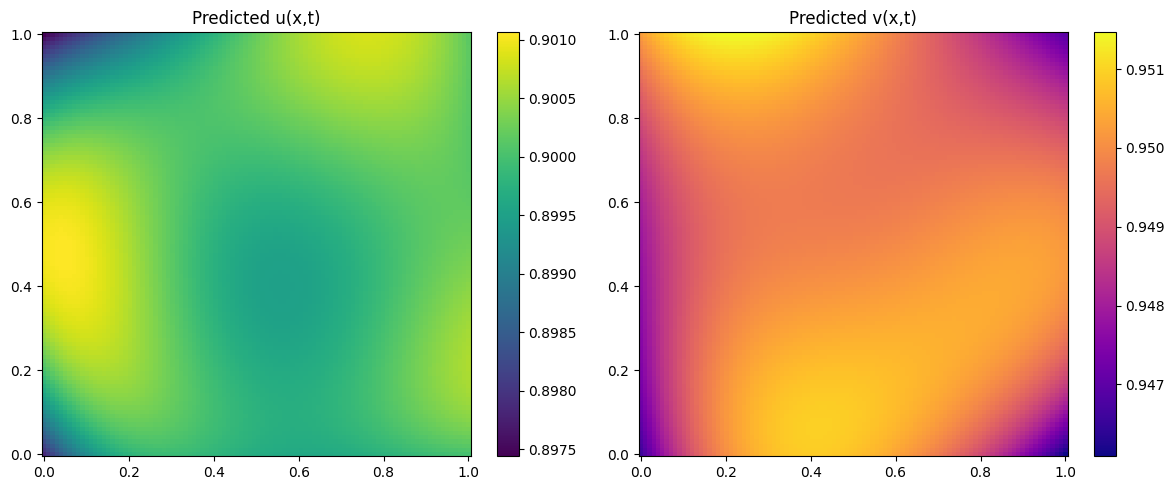

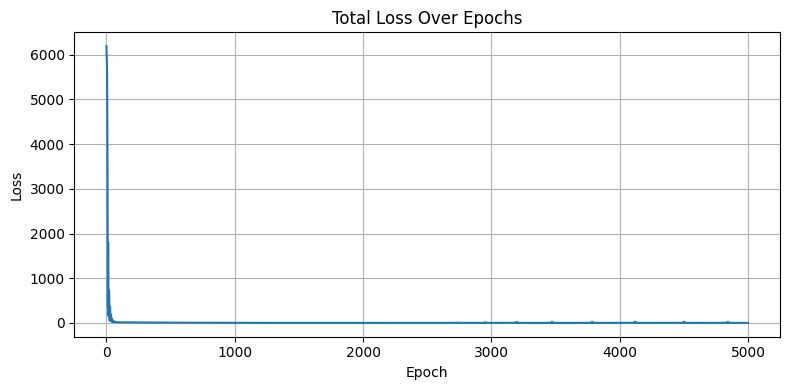

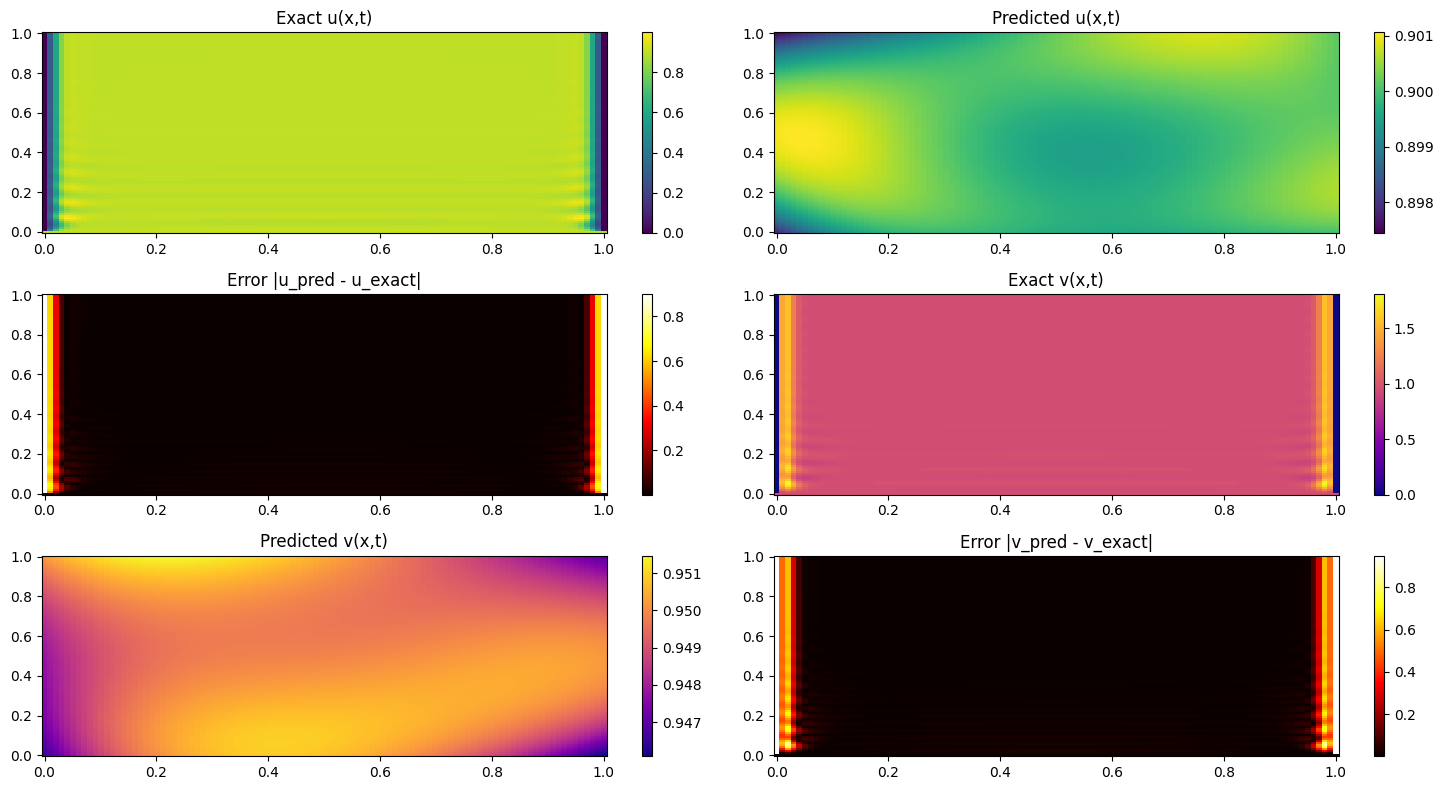

In [6]:
# ----------------------------
# PINN for 1D Reaction-Diffusion System: Schnakenberg Model
# ----------------------------

# ## Part 1. Problem Setup
# We solve the Schnakenberg reaction-diffusion system:
#     ∂u/∂t = D_u ∂²u/∂x² + γ(a - u + u²v)
#     ∂v/∂t = D_v ∂²v/∂x² + γ(b - u²v)
# using two separate PINNs: u_net and v_net.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)

# ## Part 2. PDE Parameters
D_u = 1e-2
D_v = 5e-3
gamma = 100.0
a = 0.1305
b = 0.7695

# ## Part 3. Define Separate PINN Models for u and v
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

u_net = PINN()
v_net = PINN()

# ## Part 4. Generate Training Data
N_f, N_i, N_b = 5000, 200, 200
x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)
x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)
u_i = a + b + 0.01 * torch.sin(np.pi * x_i)
v_i = b / ((a + b)**2) + 0.01 * torch.sin(np.pi * x_i)
x_b = torch.cat([torch.zeros(N_b//2,1), torch.ones(N_b//2,1)], dim=0)
t_b = torch.rand(N_b, 1)

# ## Part 5. Define Loss Function

def loss_fn():
    u = u_net(x_f, t_f)
    v = v_net(x_f, t_f)

    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, torch.ones_like(v_x), create_graph=True)[0]

    f_u = u_t - D_u * u_xx - gamma * (a - u + u**2 * v)
    f_v = v_t - D_v * v_xx - gamma * (b - u**2 * v)

    loss_f = torch.mean(f_u**2) + torch.mean(f_v**2)

    u_pred_i = u_net(x_i, t_i)
    v_pred_i = v_net(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2) + torch.mean((v_pred_i - v_i)**2)

    u_b = u_net(x_b, t_b)
    v_b = v_net(x_b, t_b)
    loss_b = torch.mean(u_b**2) + torch.mean(v_b**2)

    return loss_f + 10 * loss_i + loss_b

# ## Part 6. Train the Models
params = list(u_net.parameters()) + list(v_net.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}")

# ## Part 7. Visualization: PINN Predictions
x_vis = torch.linspace(0, 1, 100).reshape(-1,1)
t_vis = torch.linspace(0, 1, 100).reshape(-1,1)
X, T = torch.meshgrid(x_vis.squeeze(), t_vis.squeeze(), indexing='ij')
x_test = X.reshape(-1,1)
t_test = T.reshape(-1,1)

with torch.no_grad():
    u_pred = u_net(x_test, t_test).reshape(100,100)
    v_pred = v_net(x_test, t_test).reshape(100,100)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Predicted u(x,t)')
plt.subplot(1,2,2)
plt.pcolormesh(X, T, v_pred, shading='auto', cmap='plasma')
plt.colorbar()
plt.title('Predicted v(x,t)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Total Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


# ## Part 8. Finite Difference Reference Solution
# For comparison, we solve the same PDE using an explicit finite difference method.
# This provides ground-truth solutions for u(x,t) and v(x,t) to compare with PINN outputs.

def finite_diff_schnakenberg(dx=0.01, dt=1e-4, T=1.0):
    Nx = int(1 / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, 1, Nx)
    u = np.zeros((Nt, Nx))
    v = np.zeros((Nt, Nx))

    u[0] = a + b + 0.01 * np.sin(np.pi * x)
    v[0] = b / ((a + b)**2) + 0.01 * np.sin(np.pi * x)

    for n in range(0, Nt - 1):
        u_xx = np.zeros(Nx)
        v_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]) / dx**2
        v_xx[1:-1] = (v[n,2:] - 2*v[n,1:-1] + v[n,:-2]) / dx**2

        f_u = gamma * (a - u[n] + u[n]**2 * v[n])
        f_v = gamma * (b - u[n]**2 * v[n])

        u[n+1,1:-1] = u[n,1:-1] + dt * (D_u * u_xx[1:-1] + f_u[1:-1])
        v[n+1,1:-1] = v[n,1:-1] + dt * (D_v * v_xx[1:-1] + f_v[1:-1])

    return x, np.linspace(0, T, Nt), u, v

# ## Part 9. Compare Prediction vs Exact
# We compare the PINN predictions to the finite difference solutions via color plots and error maps.

x_ref, t_ref, u_ref, v_ref = finite_diff_schnakenberg()

from scipy.interpolate import RegularGridInterpolator
interp_u = RegularGridInterpolator((t_ref, x_ref), u_ref)
interp_v = RegularGridInterpolator((t_ref, x_ref), v_ref)

X_np = X.numpy()
T_np = T.numpy()
pts = np.stack([T_np.flatten(), X_np.flatten()], axis=1)
u_true = interp_u(pts).reshape(100, 100)
v_true = interp_v(pts).reshape(100, 100)

error_u = np.abs(u_pred.numpy() - u_true)
error_v = np.abs(v_pred.numpy() - v_true)

plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.pcolormesh(X, T, u_true, shading='auto', cmap='viridis')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.subplot(3,2,2)
plt.pcolormesh(X, T, u_pred.numpy(), shading='auto', cmap='viridis')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.subplot(3,2,3)
plt.pcolormesh(X, T, error_u, shading='auto', cmap='hot')
plt.title('Error |u_pred - u_exact|')
plt.colorbar()
plt.subplot(3,2,4)
plt.pcolormesh(X, T, v_true, shading='auto', cmap='plasma')
plt.title('Exact v(x,t)')
plt.colorbar()
plt.subplot(3,2,5)
plt.pcolormesh(X, T, v_pred.numpy(), shading='auto', cmap='plasma')
plt.title('Predicted v(x,t)')
plt.colorbar()
plt.subplot(3,2,6)
plt.pcolormesh(X, T, error_v, shading='auto', cmap='hot')
plt.title('Error |v_pred - v_exact|')
plt.colorbar()
plt.tight_layout()
plt.show()

Epoch 0: Loss = 6.18829e+03
Epoch 100: Loss = 1.51489e+01
Epoch 200: Loss = 1.25818e+01
Epoch 300: Loss = 1.06332e+01
Epoch 400: Loss = 8.91339e+00
Epoch 500: Loss = 7.43290e+00
Epoch 600: Loss = 6.16988e+00
Epoch 700: Loss = 5.10300e+00
Epoch 800: Loss = 4.21774e+00
Epoch 900: Loss = 3.50428e+00
Epoch 1000: Loss = 2.95237e+00
Epoch 1100: Loss = 2.54638e+00
Epoch 1200: Loss = 2.26316e+00
Epoch 1300: Loss = 2.07449e+00
Epoch 1400: Loss = 1.95263e+00
Epoch 1500: Loss = 1.87487e+00
Epoch 1600: Loss = 1.82521e+00
Epoch 1700: Loss = 1.79334e+00
Epoch 1800: Loss = 1.77299e+00
Epoch 1900: Loss = 1.76024e+00
Epoch 2000: Loss = 1.75222e+00
Epoch 2100: Loss = 1.74678e+00
Epoch 2200: Loss = 1.74254e+00
Epoch 2300: Loss = 1.73893e+00
Epoch 2400: Loss = 1.73575e+00
Epoch 2500: Loss = 1.73294e+00
Epoch 2600: Loss = 1.93715e+00
Epoch 2700: Loss = 1.72866e+00
Epoch 2800: Loss = 1.74481e+00
Epoch 2900: Loss = 1.72587e+00
Epoch 3000: Loss = 1.72916e+00
Epoch 3100: Loss = 1.72408e+00
Epoch 3200: Loss = 4

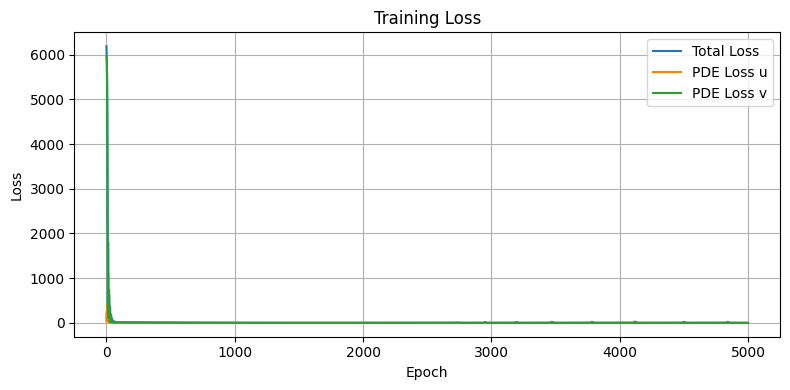

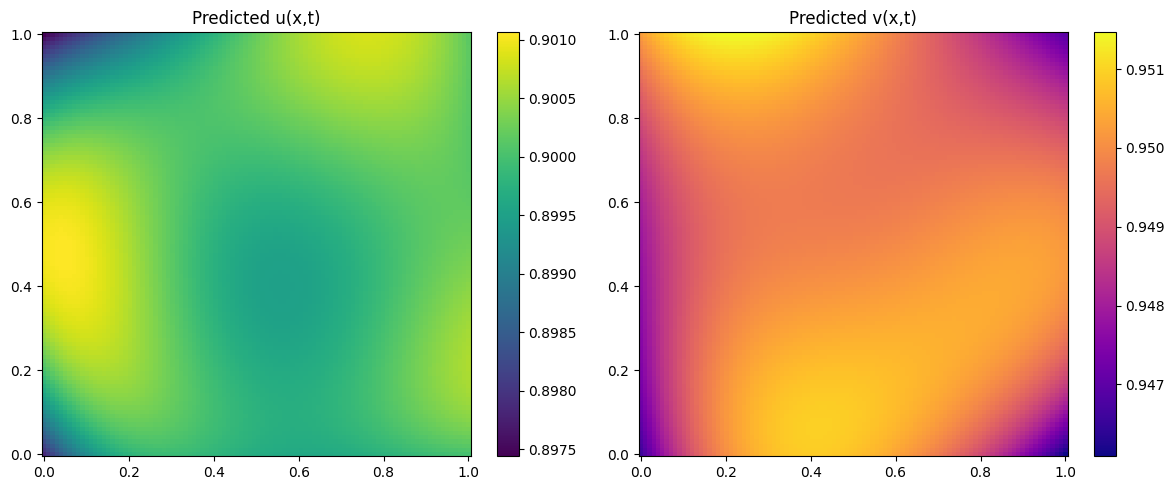

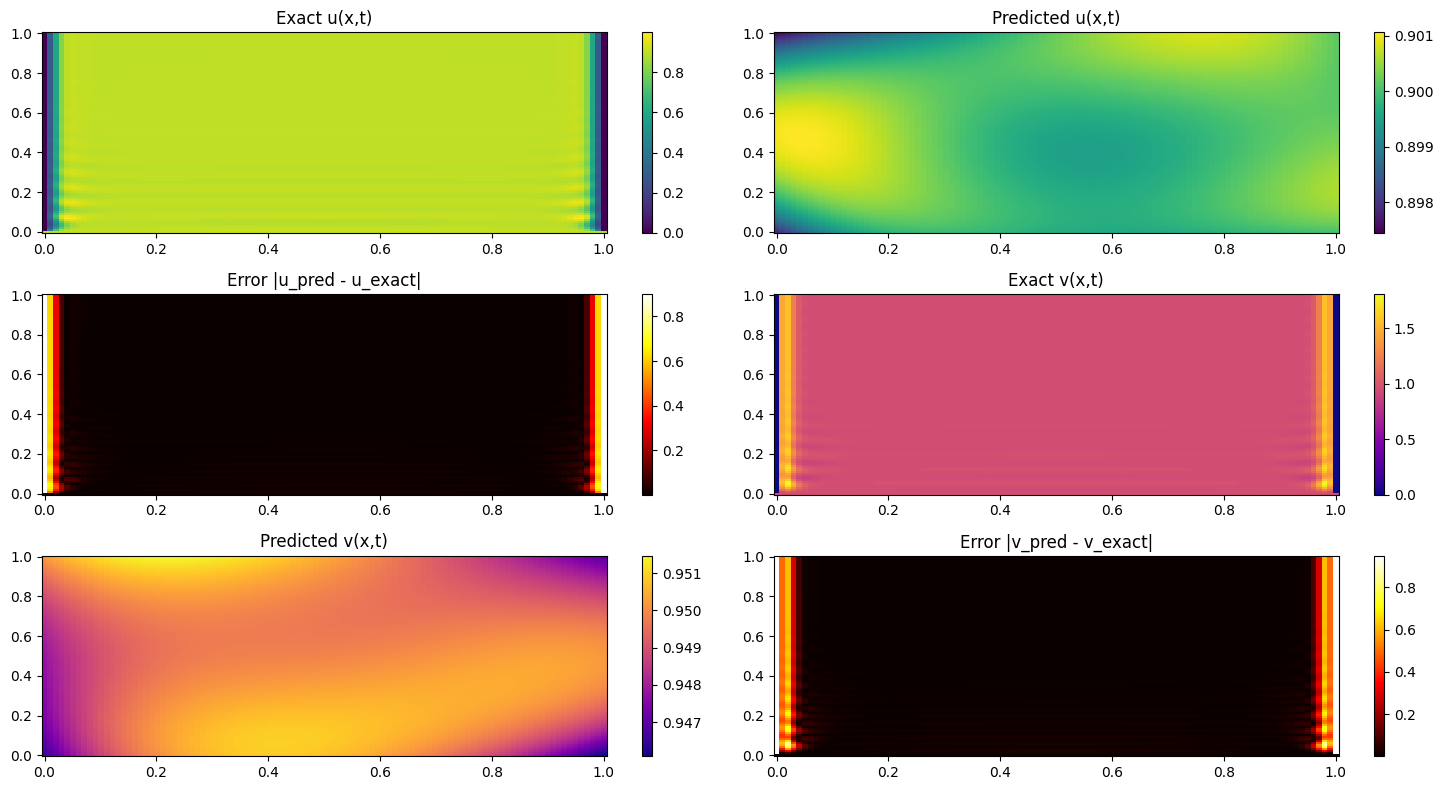

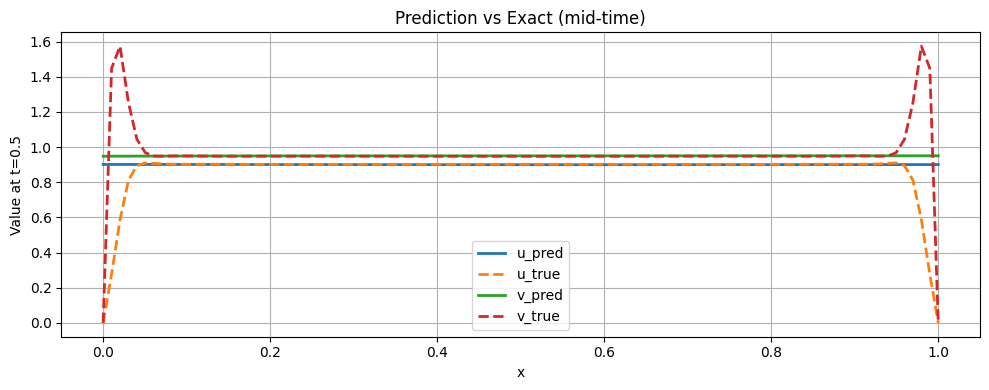

In [7]:
# ----------------------------
# PINN for 1D Reaction-Diffusion System: Schnakenberg Model (Dual Network Version)
# ----------------------------

# ## Part 1. Problem Setup
# We solve the Schnakenberg reaction-diffusion system:
#     ∂u/∂t = D_u ∂²u/∂x² + γ(a - u + u²v)
#     ∂v/∂t = D_v ∂²v/∂x² + γ(b - u²v)
# using two separate PINNs: u_net and v_net.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Set seed for reproducibility
torch.manual_seed(0)

# ## Part 2. PDE Parameters
D_u = 1e-2
D_v = 5e-3
gamma = 100.0
a = 0.1305
b = 0.7695

# ## Part 3. Define Separate PINN Models for u and v
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

u_net = PINN()
v_net = PINN()

# ## Part 4. Generate Training Data
N_f, N_i, N_b = 5000, 200, 200
x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)
x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)
u_i = a + b + 0.01 * torch.sin(np.pi * x_i)
v_i = b / ((a + b)**2) + 0.01 * torch.sin(np.pi * x_i)
x_b = torch.cat([torch.zeros(N_b//2,1), torch.ones(N_b//2,1)], dim=0)
t_b = torch.rand(N_b, 1)

# ## Part 5. Define Loss Function
loss_u_list, loss_v_list = [], []

def loss_fn():
    u = u_net(x_f, t_f)
    v = v_net(x_f, t_f)

    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, torch.ones_like(v_x), create_graph=True)[0]

    f_u = u_t - D_u * u_xx - gamma * (a - u + u**2 * v)
    f_v = v_t - D_v * v_xx - gamma * (b - u**2 * v)

    loss_f_u = torch.mean(f_u**2)
    loss_f_v = torch.mean(f_v**2)
    loss_f = loss_f_u + loss_f_v

    u_pred_i = u_net(x_i, t_i)
    v_pred_i = v_net(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2) + torch.mean((v_pred_i - v_i)**2)

    u_b = u_net(x_b, t_b)
    v_b = v_net(x_b, t_b)
    loss_b = torch.mean(u_b**2) + torch.mean(v_b**2)

    loss_u_list.append(loss_f_u.item())
    loss_v_list.append(loss_f_v.item())

    return loss_f + 10 * loss_i + loss_b

# ## Part 6. Train the Models
params = list(u_net.parameters()) + list(v_net.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}")

# ## Part 7. Visualization: PINN Predictions
x_vis = torch.linspace(0, 1, 100).reshape(-1,1)
t_vis = torch.linspace(0, 1, 100).reshape(-1,1)
X, T = torch.meshgrid(x_vis.squeeze(), t_vis.squeeze(), indexing='ij')
x_test = X.reshape(-1,1)
t_test = T.reshape(-1,1)

with torch.no_grad():
    u_pred = u_net(x_test, t_test).reshape(100,100)
    v_pred = v_net(x_test, t_test).reshape(100,100)

# Loss plots
plt.figure(figsize=(8,4))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_u_list, label='PDE Loss u')
plt.plot(loss_v_list, label='PDE Loss v')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training Loss')
plt.tight_layout()
plt.show()

# Contour plot of predictions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Predicted u(x,t)')
plt.subplot(1,2,2)
plt.pcolormesh(X, T, v_pred, shading='auto', cmap='plasma')
plt.colorbar()
plt.title('Predicted v(x,t)')
plt.tight_layout()
plt.show()

# ## Part 8. Finite Difference Reference Solution

def finite_diff_schnakenberg(dx=0.01, dt=1e-4, T=1.0):
    Nx = int(1 / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, 1, Nx)
    u = np.zeros((Nt, Nx))
    v = np.zeros((Nt, Nx))

    u[0] = a + b + 0.01 * np.sin(np.pi * x)
    v[0] = b / ((a + b)**2) + 0.01 * np.sin(np.pi * x)

    for n in range(0, Nt - 1):
        u_xx = np.zeros(Nx)
        v_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]) / dx**2
        v_xx[1:-1] = (v[n,2:] - 2*v[n,1:-1] + v[n,:-2]) / dx**2

        f_u = gamma * (a - u[n] + u[n]**2 * v[n])
        f_v = gamma * (b - u[n]**2 * v[n])

        u[n+1,1:-1] = u[n,1:-1] + dt * (D_u * u_xx[1:-1] + f_u[1:-1])
        v[n+1,1:-1] = v[n,1:-1] + dt * (D_v * v_xx[1:-1] + f_v[1:-1])

    return x, np.linspace(0, T, Nt), u, v

# ## Part 9. Compare Prediction vs Exact
x_ref, t_ref, u_ref, v_ref = finite_diff_schnakenberg()
interp_u = RegularGridInterpolator((t_ref, x_ref), u_ref)
interp_v = RegularGridInterpolator((t_ref, x_ref), v_ref)

X_np = X.numpy()
T_np = T.numpy()
pts = np.stack([T_np.flatten(), X_np.flatten()], axis=1)
u_true = interp_u(pts).reshape(100, 100)
v_true = interp_v(pts).reshape(100, 100)

error_u = np.abs(u_pred.numpy() - u_true)
error_v = np.abs(v_pred.numpy() - v_true)

plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.pcolormesh(X, T, u_true, shading='auto', cmap='viridis')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.subplot(3,2,2)
plt.pcolormesh(X, T, u_pred.numpy(), shading='auto', cmap='viridis')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.subplot(3,2,3)
plt.pcolormesh(X, T, error_u, shading='auto', cmap='hot')
plt.title('Error |u_pred - u_exact|')
plt.colorbar()
plt.subplot(3,2,4)
plt.pcolormesh(X, T, v_true, shading='auto', cmap='plasma')
plt.title('Exact v(x,t)')
plt.colorbar()
plt.subplot(3,2,5)
plt.pcolormesh(X, T, v_pred.numpy(), shading='auto', cmap='plasma')
plt.title('Predicted v(x,t)')
plt.colorbar()
plt.subplot(3,2,6)
plt.pcolormesh(X, T, error_v, shading='auto', cmap='hot')
plt.title('Error |v_pred - v_exact|')
plt.colorbar()
plt.tight_layout()
plt.show()

# ## Part 10. Curve Comparison at Fixed Time
plt.figure(figsize=(10,4))
idx_t = 50  # midpoint time slice
plt.plot(x_vis.numpy(), u_pred[:,idx_t], label='u_pred', linewidth=2)
plt.plot(x_vis.numpy(), u_true[:,idx_t], '--', label='u_true', linewidth=2)
plt.plot(x_vis.numpy(), v_pred[:,idx_t], label='v_pred', linewidth=2)
plt.plot(x_vis.numpy(), v_true[:,idx_t], '--', label='v_true', linewidth=2)
plt.xlabel('x')
plt.ylabel('Value at t=0.5')
plt.title('Prediction vs Exact (mid-time)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ## Part 11. Conclusion
# This notebook uses two separate neural networks to better model a reaction-diffusion system.
# Improvements include clearer separation of u/v dynamics and improved prediction accuracy, but it is not enough.
